In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
import time
from datetime import datetime
from google.cloud.logging import DESCENDING, Client
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.titlesize'] = 18

In [3]:
client = Client(project='ultra-sound-relay')

/usr/local/lib/python3.8/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [74]:
start = pd.Timestamp('2023-04-25 16:10:00.000000')
now = pd.Timestamp.utcnow()
start,now

(Timestamp('2023-04-25 16:10:00'),
 Timestamp('2023-04-25 17:31:55.889167+0000', tz='UTC'))

In [75]:
filter_ = 'resource.labels.cluster_name="midori" AND ' + \
           'jsonPayload.method="submitNewBlockV2" AND ' + \
           '"optimistically parsed bid and verified signature" ' + \
           'AND timestamp>=' + '\"' + (start).strftime('%Y-%m-%dT%H:%M:%S.%fZ') + '\" ' + \
           'AND timestamp<=' + '\"' + (now).strftime('%Y-%m-%dT%H:%M:%S.%fZ') + '\"'
filter_

'resource.labels.cluster_name="midori" AND jsonPayload.method="submitNewBlockV2" AND "optimistically parsed bid and verified signature" AND timestamp>="2023-04-25T16:10:00.000000Z" AND timestamp<="2023-04-25T17:31:55.889167Z"'

In [76]:
res = []
subs = pd.DataFrame(columns=['slot', 'decode_dur', 'content_length'])
for e in client.list_entries(filter_=filter_):
    res.append((e.payload['decode_time'], e.payload['contentLength']))
res = np.asarray(res)
res.shape

(1595, 2)

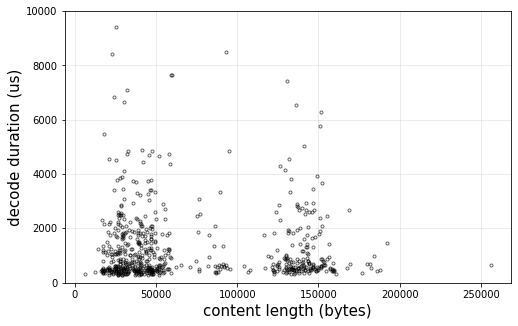

In [69]:
f, ax = plt.subplots(figsize=(8,5))

ax.plot(res[:,1], res[:,0], 'k.', fillstyle='none', alpha=0.6)

ax.set_ylim(-10, 10000)
ax.set_xlabel('content length (bytes)', size=15)
ax.set_ylabel('decode duration (us)', size=15)
plt.show()

In [77]:
durs = res[:,0]
durs[durs<10000]

array([ 949.,  392.,  607., ...,  467., 1727., 1398.])

In [80]:
len(durs), len(durs[durs<10000])

(1595, 1486)

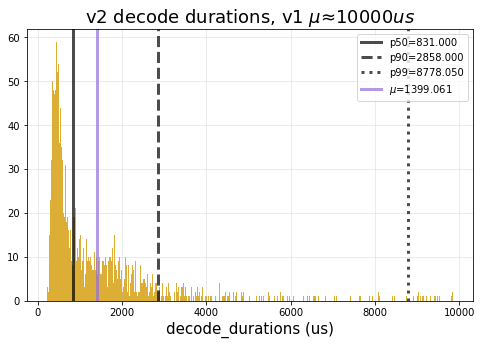

In [84]:
f, ax = plt.subplots(figsize=(8,5))

ax.hist(durs[durs<10000], color='goldenrod', alpha=0.9, bins=400)

percs = [(int(i*100), np.quantile(durs[durs<10000], i)) for i in [.50, .90, .99]]
linestyle = ['-', '--', ':']
for i, v in enumerate(percs):
    ax.axvline(v[1], label='p{}={:0.3f}'.format(v[0], v[1]), color='k', linestyle=linestyle[i], linewidth=3, alpha=0.7)
ax.axvline(durs[durs<10000].mean(), label='$\mu$={:0.3f}'.format(durs[durs<10000].mean()), color='mediumpurple', linewidth=3, alpha=0.7)

ax.legend(loc=1)
ax.set_xlabel('decode_durations (us)', size=15)
ax.set_title('v2 decode durations, v1 $\mu ≈ 10000us$')
# ax.set_ylim(-10, 10000)
plt.show()

In [37]:
res[:,0].per()

7831.44